In [13]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, schedule, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

import pandas as pd

import random

import qiskit.pulse as pulse
from qiskit.circuit import Parameter

from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal
from qiskit_experiments.library.calibration.frequency_cal import FrequencyCal
from qiskit_experiments.library.calibration.fine_frequency_cal import FineFrequencyCal

from qiskit_experiments.calibration_management.calibrations import Calibrations

from qiskit.tools.monitor import job_monitor

import matplotlib
import matplotlib.pyplot as plt

from IPython.display import HTML

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

from qiskit import transpile, schedule as build_schedule, QuantumRegister, ClassicalRegister
from qiskit.pulse import Schedule, Play, SetFrequency, Drag, Gaussian, ShiftFrequency, GaussianSquare, DriveChannel, ControlChannel, Waveform, ScheduleBlock, Acquire, AcquireChannel, MemorySlot, MeasureChannel, Delay
from qiskit.circuit import QuantumRegister, ClassicalRegister, Parameter, Gate

from qiskit.circuit import Instruction

# based on https://stackoverflow.com/questions/49503869/attributeerror-while-trying-to-load-the-pickled-matplotlib-figure
def show_figure(fig):
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)
    
# based on https://www.delftstack.com/howto/python/parallel-for-loops-python/
import asyncio
import time

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

d = lambda idx: pulse.DriveChannel(idx)
m = lambda idx: pulse.MeasureChannel(idx)
u = lambda idx: pulse.ControlChannel(idx)
a = lambda idx: pulse.AcquireChannel(idx)

provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
# provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
# backend = provider.get_backend('ibmq_casablanca')
backend = provider.get_backend('ibmq_jakarta')
# backend = QasmSimulator.from_backend(backend)

config = backend.configuration() # configuration - Hardware configuration information.
properties = backend.properties() # properties - Physical properties of the device.
defaults = backend.defaults() # defaults - Information for pulse properties that change frequently.

from qiskit.opflow import Zero, One, I, X, Y, Z

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import plot_histogram

from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho, RZXCalibrationBuilder

from qiskit.circuit.library import XGate, YGate, SXGate, RZGate

from qiskit.visualization.pulse_v2 import draw, IQXDebugging

import time
from tqdm import tqdm_notebook as tqdm

from scipy.optimize import curve_fit
import copy

ibmqfactory.load_account:WARNING:2022-04-09 07:30:22,014: Credentials are already in use. The existing account in the session will be replaced.


In [14]:
def display_gates_pulses(instructions, qubits, inst_map):
    for qubit in qubits:
        for instruction in instructions:
            print(inst_map.get(instruction, qubit))

def update_drag_parameter(qubit, instruction, parameter, new_value, inst_map):
    old_sched = inst_map.pop(instruction, qubit)
    for instr_ in old_sched.instructions:
        if isinstance(instr_[1], pulse.instructions.play.Play):
            if isinstance(instr_[1].operands[0], pulse.Drag):
                duration = new_value if parameter == 'duration' else instr_[1].operands[0].duration
                amp = new_value if parameter == 'amp' else instr_[1].operands[0].amp
                sigma = new_value if parameter == 'sigma' else instr_[1].operands[0].sigma
                beta = new_value if parameter == 'beta' else instr_[1].operands[0].beta
                name = new_value if parameter == 'name' else instr_[1].operands[0].name
    # new_sched = SetFrequency(qubit_freq_cal[qubit], d(qubit)) + Play(Drag(duration, amp, sigma, beta, name), d(qubit))
    new_sched = Schedule()
    # new_sched = ShiftFrequency(0, d(qubit)) + Play(Drag(duration, amp, sigma, beta, name), d(qubit))
    new_sched += Play(Drag(duration, amp, sigma, beta, name), d(qubit))    
    inst_map.add(instruction, qubit, new_sched)
    
def update_cal_from_inst_map(qubits, instructions, cal, inst_map):
    for qubit in qubits:
        for instruction in instructions:
            sched = inst_map.get(instruction, qubit)
            for instr_ in sched.instructions:
                if isinstance(instr_[1], pulse.instructions.play.Play):
                    if isinstance(instr_[1].operands[0], pulse.Drag):
                        duration = instr_[1].operands[0].duration
                        amp = instr_[1].operands[0].amp
                        sigma = instr_[1].operands[0].sigma
                        beta = instr_[1].operands[0].beta
                        name = instr_[1].operands[0].name
                        # print(qubit, instruction, ":", duration, amp, sigma, beta)
                        cal.add_parameter_value(amp, 'amp', qubit, instruction)
                        cal.add_parameter_value(duration, 'duration', qubit, instruction)
                        cal.add_parameter_value(sigma, 'σ', qubit, instruction)
                        cal.add_parameter_value(beta, 'β', qubit, instruction)    
    
def update_inst_map_from_cal(qubits, instructions, cal, inst_map):
    for qubit in qubits:
        for instruction in instructions:
            update_drag_parameter(qubit, instruction, 'amp', cal.get_parameter_value('amp', qubit, instruction), inst_map)
            update_drag_parameter(qubit, instruction, 'beta', cal.get_parameter_value('β', qubit, instruction), inst_map)
            update_drag_parameter(qubit, instruction, 'sigma', cal.get_parameter_value('σ', qubit, instruction), inst_map)
            update_drag_parameter(qubit, instruction, 'duration', cal.get_parameter_value('duration', qubit, instruction), inst_map)


In [15]:
qubits = [0, 1, 2, 3, 4, 5, 6]

duration = 10*16

inst_map_cal = pulse.InstructionScheduleMap() # instruction map with tunned ibm calibration settings
inst_map_ncal = pulse.InstructionScheduleMap() # instruction map with default ibm calibration settings

for instruction in defaults.instruction_schedule_map.instructions:
    if instruction not in  ['cx', 'u1', 'u2', 'u3']:
        for qubit in qubits:
            inst_map_cal.add(instruction, qubit, defaults.instruction_schedule_map.get(instruction, qubit))
            inst_map_ncal.add(instruction, qubit, defaults.instruction_schedule_map.get(instruction, qubit))
            
inst_map_cal.add('measure', range(config.n_qubits), 
             defaults.instruction_schedule_map.get('measure', range(config.n_qubits)))
inst_map_ncal.add('measure', range(config.n_qubits), 
             defaults.instruction_schedule_map.get('measure', range(config.n_qubits)))

cx_qubits = [(1,3), (3,1), (3,5), (5, 3)]
for qubit in cx_qubits:
    inst_map_cal.add('cx', qubit, defaults.instruction_schedule_map.get('cx', qubit))
    inst_map_ncal.add('cx', qubit, defaults.instruction_schedule_map.get('cx', qubit))

for instruction in ['sx','x']:
    for qubit in qubits:
        update_drag_parameter(qubit, instruction, 'duration', duration, inst_map_cal)

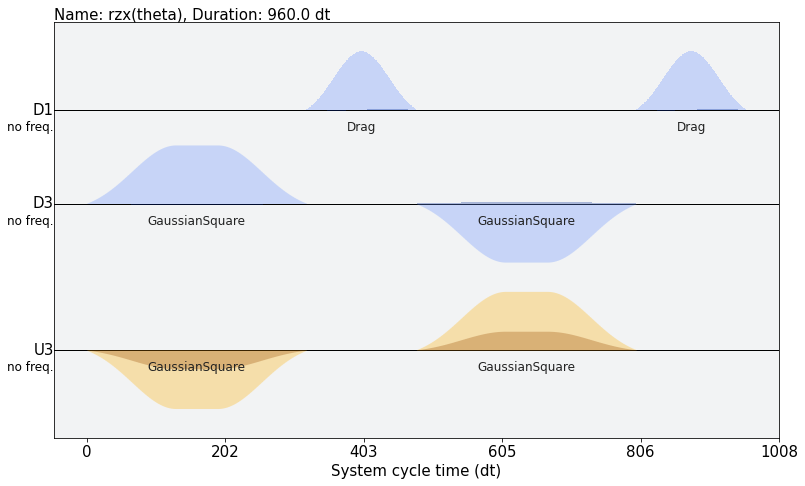

In [16]:
RzxCal = RZXCalibrationBuilder(backend=backend, instruction_schedule_map=inst_map_cal)
RzxCalNoEcho = RZXCalibrationBuilderNoEcho(backend=backend, instruction_schedule_map=inst_map_cal)

def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

def rzx_cal(qubits, theta, amp_mul=1.0, amp=None, amp_t=None, duration=None, sigma=None, x_cal=False, waveform=None):
    theta_ = Instruction('theta', 7, 7, params=[theta])
    def_rzx_cal = RzxCal.get_calibration(theta_, qubits)
    # show_figure(def_rzx_cal.draw(style=IQXDebugging()))
    
    amp_dr_, amp_ctr_, sigma_, width_, duration_, ctr_ch_, dr_ch_ = None, None, None, None, None, None, None
    x_amp_, x_beta_, x_sigma_, x_duration_, x_dr_ch_ = None, None, None, None, None
    for instr_ in def_rzx_cal.instructions:
        
        if isinstance(instr_[1], pulse.instructions.play.Play):
            if isinstance(instr_[1].operands[0], pulse.GaussianSquare):
                if isinstance(instr_[1].channel, pulse.channels.ControlChannel):
                    # CR control
                    if amp_ctr_ is None:
                        # print(instr_[1].operands[0])
                        amp_ctr_ = instr_[1].operands[0].amp
                        ctr_ch_ = instr_[1].channel.index
                else:
                    #CR drive
                    if amp_dr_ is None:
                        # print(instr_[1].operands[0])
                        amp_dr_ = instr_[1].operands[0].amp
                        sigma_ = instr_[1].operands[0].sigma
                        duration_ = instr_[1].operands[0].duration
                        width_ = instr_[1].operands[0].width
                        dr_ch_ = instr_[1].channel.index
            if isinstance(instr_[1].operands[0], pulse.Drag):
                # X pulses
                if x_amp_ is None:
                    # print(instr_[1].operands[0])
                    x_duration_ = instr_[1].operands[0].duration
                    x_amp_ = instr_[1].operands[0].amp
                    x_beta_ = instr_[1].operands[0].beta
                    x_dr_ch_ = instr_[1].channel.index
                    x_sigma_ = instr_[1].operands[0].sigma
                    
    if amp is not None:
        if amp[0] is not None:
            amp_ctr_ = amp[0]+amp_ctr_.imag*1j
        if amp[1] is not None:
            amp_ctr_ = amp_ctr_.real+amp[1]
            
    if amp_t is not None:
        if amp_t[0] is not None:
            amp_dr_ = amp_t[0]+amp_dr_.imag*1j
        if amp_t[1] is not None:
            amp_dr_ = amp_dr_.real+amp_t[1]
                       
    if duration is not None:
        duration = get_closest_multiple_of_16(duration)
        width_ = duration/duration_ * width_
        duration_ = duration
        
    if sigma is not None:
        sigma_ = sigma
        
    if x_cal:
        x_cal = inst_map_cal.get('x', x_dr_ch_)
        x_amp_, x_beta_, x_sigma_, x_duration_ = x_cal.instructions[0][1].operands[0].amp, x_cal.instructions[0][1].operands[0].beta, \
                                                 x_cal.instructions[0][1].operands[0].sigma, x_cal.instructions[0][1].operands[0].duration
        
    amp_ctr_ *= amp_mul
    amp_dr_ *= amp_mul

    if waveform is None:
        rzx_cal = Schedule((0, Play(GaussianSquare(duration=duration_, amp=amp_dr_, sigma=sigma_, width=width_), DriveChannel(dr_ch_))),
                       (0, Play(GaussianSquare(duration=duration_, amp=amp_ctr_, sigma=sigma_, width=width_), ControlChannel(ctr_ch_))),
                       (duration_, Play(Drag(duration=x_duration_, amp=x_amp_, sigma=x_sigma_, beta=x_beta_), DriveChannel(x_dr_ch_), name='Xp_d5')),
                       (duration_+x_duration_, Play(GaussianSquare(duration=duration_, amp=-amp_dr_, sigma=sigma_, width=width_), DriveChannel(dr_ch_))),
                       (duration_+x_duration_, Play(GaussianSquare(duration=duration_, amp=-amp_ctr_, sigma=sigma_, width=width_), ControlChannel(ctr_ch_))),
                       (2*duration_+x_duration_, Play(Drag(duration=x_duration_, amp=x_amp_, sigma=x_sigma_, beta=x_beta_), DriveChannel(x_dr_ch_), name='Xp_d5')),
                       name="rzx(theta)")
    else:
        rzx_cal = Schedule((0, Play(Waveform(waveform), ControlChannel(ctr_ch_))),
                       (duration_, Play(Drag(duration=x_duration_, amp=x_amp_, sigma=x_sigma_, beta=x_beta_), DriveChannel(x_dr_ch_), name='Xp_d5')),
                       (duration_+x_duration_, Play(Waveform([-x for x in waveform]), ControlChannel(ctr_ch_))),
                       (2*duration_+x_duration_, Play(Drag(duration=x_duration_, amp=x_amp_, sigma=x_sigma_, beta=x_beta_), DriveChannel(x_dr_ch_), name='Xp_d5')),
                       name="rzx(theta)")
        
    return rzx_cal

rzx_cal((1,3), 2*np.pi/11, amp_mul=1.0, duration=None, x_cal=True, waveform=None).draw()

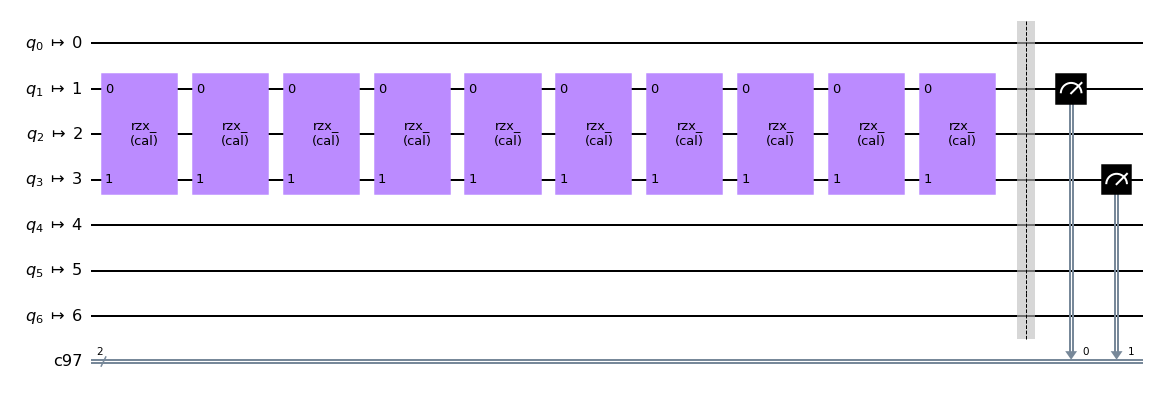

In [17]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
def rzx_experiment(qubits, repetitions, control, target, target_time, trotter_steps, amp_mul=1.0):
    q0 = qubits[0] # control
    q1 = qubits[1] # target
    
    qc = QuantumCircuit(7)

    if control == 1:
        qc.x(q0)
    if target == 1:
        qc.x(q1)

    rzx_gate = Gate('rzx_', 2, [])
    for _ in range(repetitions):
        qc.append(rzx_gate, [q0, q1])

    rzx_q0q1_sched = rzx_cal((q0,q1), 2*target_time/trotter_steps, amp_mul=amp_mul, x_cal=True)
    qc.add_calibration('rzx_', (q0,q1), rzx_q0q1_sched)
    inst_map_cal.add('rzx_', (q0,q1), rzx_q0q1_sched)
    
    qc = state_tomography_circuits(qc, [q0, q1])
    qc_transpile = transpile(qc, backend, optimization_level=0, basis_gates=inst_map_cal.instructions)
    return qc_transpile

rzx_experiment(qubits=[1,3], repetitions=10, control=0, target=0, target_time=np.pi, trotter_steps=7, amp_mul=1.1)[-1].draw()

In [18]:
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.quantum_info import state_fidelity, Statevector

def rzx_target_state(repetitions, control, target, target_time, trotter_steps):
    qc = QuantumCircuit(2)
    if control == 1:
        qc.x(0)
    if target == 1:
        qc.x(1)

    for _ in range(repetitions):
        qc.rzx(2*target_time/trotter_steps, 0,1)

    target_state_rzx = Statevector.from_instruction(qc)
    # print(target_state_rzx)
    return target_state_rzx

rzx_target_state(repetitions=10, control=0, target=0, target_time=np.pi, trotter_steps=7)

Statevector([-0.22252093+0.j        ,  0.        +0.j        ,
              0.        +0.97492791j,  0.        +0.j        ],
            dims=(2, 2))


In [19]:
def gen_experiments(qubits_, target_time, trotter_steps, amp_mul):
    experiments = []
    circuits = []
    for exp_idx in range(0, 8):
        repetitions = (exp_idx+1)*4
        target_state = rzx_target_state(repetitions=repetitions, control=0, target=0, target_time=np.pi, trotter_steps=trotter_steps)
        experiments.append({'qubits': qubits_, 'repetitions': repetitions, 'amp_mul': amp_mul, 'control': 0, 'target': 0, 'target_state': target_state})
        circuits.append(None)

        target_state = rzx_target_state(repetitions=repetitions, control=0, target=1, target_time=np.pi, trotter_steps=trotter_steps)
        experiments.append({'qubits': qubits_, 'repetitions': repetitions, 'amp_mul': amp_mul, 'control': 0, 'target': 1, 'target_state': target_state})
        circuits.append(None)

        target_state = rzx_target_state(repetitions=repetitions, control=1, target=0, target_time=np.pi, trotter_steps=trotter_steps)
        experiments.append({'qubits': qubits_, 'repetitions': repetitions, 'amp_mul': amp_mul, 'control': 1, 'target': 0, 'target_state': target_state})
        circuits.append(None)

        target_state = rzx_target_state(repetitions=repetitions, control=1, target=1, target_time=np.pi, trotter_steps=trotter_steps)
        experiments.append({'qubits': qubits_, 'repetitions': repetitions, 'amp_mul': amp_mul, 'control': 1, 'target': 1, 'target_state': target_state})
        circuits.append(None)
    return experiments, circuits

In [ ]:
def state_tomo(result, st_qcs, target_state_rzx):
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    fid = state_fidelity(rho_fit, target_state_rzx)
    return fid

num_tomo_circ_2q = 3**2

def view_results(experiments, num_tomo_circ_2q):
    fids = []
    for idx, exp in enumerate(experiments):
        target_state_rzx = exp['target_state']

        results = copy.deepcopy(jobs.result())
        results_dict = results.to_dict()
        results_dict['results'] = results.to_dict()['results'][idx*num_tomo_circ_2q:(idx+1)*num_tomo_circ_2q]
        results = results.from_dict(results_dict)

        fid = state_tomo(results, circuits[idx], exp['target_state'])
        fids.append(fid)
        color = 'blue' if exp['target'] == 0 and exp['control'] == 0 else ''
        color = 'green' if exp['target'] == 1 and exp['control'] == 0 else color
        color = 'red' if exp['target'] == 0 and exp['control'] == 1 else color
        color = 'cyan' if exp['target'] == 1 and exp['control'] == 1 else color
        plt.scatter(exp['repetitions'], fid, color=color)

    plt.legend(["c=|0> t=|0>", "c=|0> t=|1>", "c=|1> t=|0>", "c=|1> t=|1>"])
    plt.show()

    print(float(sum(fids))/len(fids))

In [9]:
jobs = []

qubits_ = [3,5]
target_time = np.pi
trotter_steps = 11
amp_mul = 1.15

# TODO calibrate inverse gates
    
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

def execute_experiments():
    qcs_ = []
    for idx, exp in enumerate(experiments):
        qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
        circuits[idx] = qc
        qcs_.extend(qc)
        
    job = execute(qcs_, backend, meas_level=2, shots=10000, optimization_level=0, inst_map=inst_map_cal)
    # print("")
    # job_monitor(job)
    # jobs[idx] = job

execute_experiments()

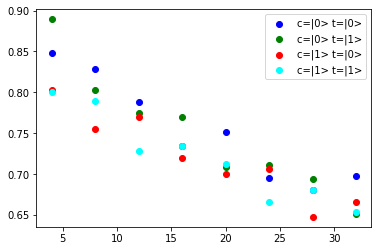

0.7360903640365816


In [29]:
jobs = backend.retrieve_job("62494b1be978c7f084fb1f1a")

amp_mul = 1.02
qubits_ = [1, 3]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)
    
view_results(experiments, num_tomo_circ_2q)

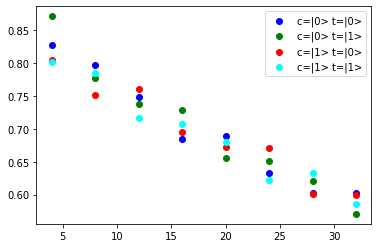

0.6960775312851418


In [30]:
jobs = backend.retrieve_job("62494b9eb3213d5003c06190")

amp_mul = 0.98
qubits_ = [1, 3]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)
    
view_results(experiments, num_tomo_circ_2q)

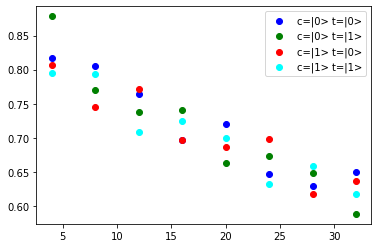

0.710013185038697


In [31]:
jobs = backend.retrieve_job("62498d6abe9f6002467718c8")

amp_mul = 1.0
qubits_ = [1, 3]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)
    
view_results(experiments, num_tomo_circ_2q)

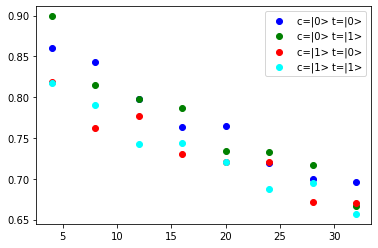

0.7505797358618823


In [32]:
jobs = backend.retrieve_job("62499ba7133bfd7c955ac012")

amp_mul = 1.04
qubits_ = [1, 3]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)
    
view_results(experiments, num_tomo_circ_2q)

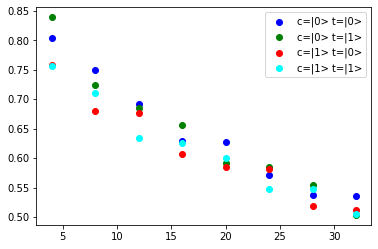

0.6290253673983223


In [33]:
jobs = backend.retrieve_job("6249a6e31a95e0005d5cdcd7")

amp_mul = 0.99
qubits_ = [1, 3]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)
    
view_results(experiments, num_tomo_circ_2q)

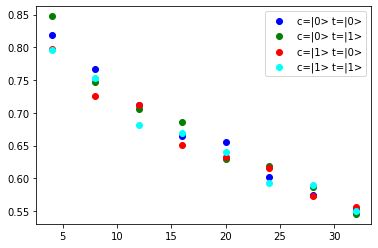

0.6640017082862911


In [34]:
jobs = backend.retrieve_job("6249a91ce978c79abcfb1fc8")

amp_mul = 1.005
qubits_ = [1, 3]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)
    
view_results(experiments, num_tomo_circ_2q)

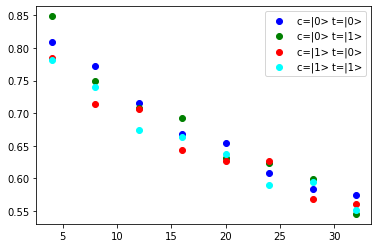

0.6641790873477401


In [35]:
jobs = backend.retrieve_job("6249a953f9156f5f85cc027c")

amp_mul = 1.0025
qubits_ = [1, 3]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)
    
view_results(experiments, num_tomo_circ_2q)

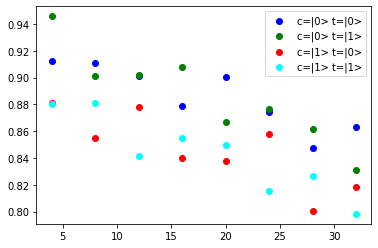

0.8655707267444924


In [36]:
jobs = backend.retrieve_job("6249f32cbe9f60f44b7719ce")

amp_mul = 1.05
qubits_ = [1, 3]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)
    
view_results(experiments, num_tomo_circ_2q)

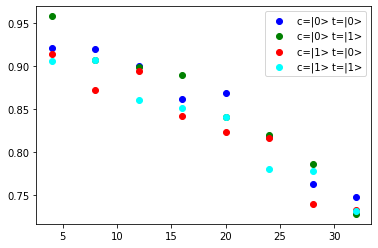

0.8411474495050132


In [37]:
jobs = backend.retrieve_job("624ab7cc99622540008bb81c")

amp_mul = 1.1
qubits_ = [1, 3]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)
    
view_results(experiments, num_tomo_circ_2q)

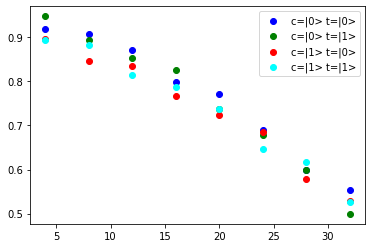

0.7473457508130223


In [38]:
jobs = backend.retrieve_job("624b42d043644d266594902b")

amp_mul = 1.15
qubits_ = [1, 3]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)
    
view_results(experiments, num_tomo_circ_2q)

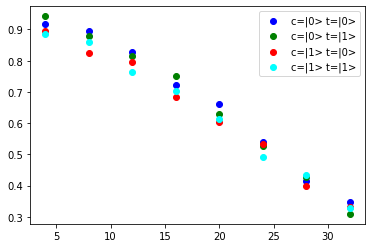

0.6483850282730962


In [39]:
jobs = backend.retrieve_job("624b4d7a6eeef18189063552")

amp_mul = 1.2
qubits_ = [1, 3]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)

view_results(experiments, num_tomo_circ_2q)

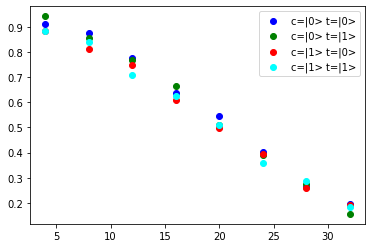

0.560850115331307


In [28]:
jobs = backend.retrieve_job("624b54868eeb14eb2ed71bfb")

amp_mul = 1.25
qubits_ = [1, 3]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)
    
view_results(experiments, num_tomo_circ_2q)

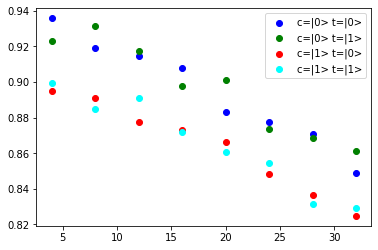

0.8802404919045008


In [27]:
jobs = backend.retrieve_job("624d324aa5d4ee302277c1d3")

amp_mul = 1.0
qubits_ = [3, 5]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)
    
view_results(experiments, num_tomo_circ_2q)

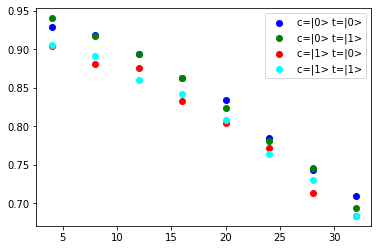

0.8212854635703716


In [26]:
jobs = backend.retrieve_job("624d322df65d78972438f742")

amp_mul = 1.05
qubits_ = [3, 5]
target_time = np.pi
trotter_steps = 11
experiments, circuits = gen_experiments(qubits_, target_time, trotter_steps, amp_mul)

circuits = []
for idx, exp in enumerate(experiments):
    qc = rzx_experiment(qubits=exp['qubits'], repetitions=exp['repetitions'], control=exp['control'], target=exp['target'], target_time=target_time, trotter_steps=trotter_steps, amp_mul=exp['amp_mul'])
    circuits.append(qc)
    
view_results(experiments, num_tomo_circ_2q)